# Feature importance rank ensembling (FIRE)

## Overview

You can extend model ensembling, which provides improved accuracy and robustness, to feature selection. Within DataRobot, this approach is based on aggregating ranks of features using Feature Impact from several blueprints from the Leaderboard.

At a high level, in this notebook you'll perform the following:

1. Calculate the permutation feature importance for the top five performing models in the Leaderboard against the selected metric. 
2. For each model with computed feature importance, get the ranking of the features.
3. Compute the median rank of each feature by aggregating the ranks of the features across all models.
4. Sort the aggregated list by the computed median rank.
5. Define the threshold number of features to select. In this case, use the number of features that account for 95% of the cumulative feature impact.
6. Create a feature list based on the newly selected features.

Visit the [DataRobot blog post](https://www.datarobot.com/blog/using-feature-importance-rank-ensembling-fire-for-advanced-feature-selection/) to learn more about this approach.

### Background

This walkthrough uses a synthetic dataset that illustrates a credit card company’s anti-money laundering (AML) compliance program, with the intent of detecting the following money-laundering scenarios:

* A customer spends on the card, but overpays their credit card bill and seeks a cash refund for the difference.
* A customer receives credits from a merchant without offsetting transactions, and either spends the money or requests a cash refund from the bank.

A rule-based engine is in place to produce an alert when it detects potentially suspicious activity consistent with the scenarios above. The engine triggers an alert whenever a customer requests a refund of any amount. Small refund requests are included because they could be a money launderer’s way of testing the refund mechanism or trying to establish refund requests as a normal pattern for their account.

The target feature is `SAR`. It indicates whether or not the alert resulted in an Suspicious Activity Report (SAR) after manual review by investigators, which means that this project is framed as a binary classification problem. The unit of analysis is an individual alert, so the model will be built on the alert level. Each alert will get a score ranging from 0 to 1, indicating the probability of being an alert leading to an SAR. The data consists of a mixture of numeric, categorical and text data.

## Setup

### Import libraries

In [2]:
import os
import sys
import time
import warnings

import datarobot as dr
import matplotlib.pyplot as plt
import pandas as pd
import requests

%matplotlib inline
import seaborn as sns

sys.path.append("..")
from fire import Fire

warnings.filterwarnings("ignore")

# Wider .head()s
pd.options.display.width = 0
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000

sns.set_theme(style="darkgrid")

RANDOM_SEED = 321

### Import data

In [3]:
df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_AML_Alert.csv"
)
df.head()

,ALERT,SAR,kycRiskScore,income,tenureMonths,creditScore,state,nbrPurchases90d,avgTxnSize90d,totalSpend90d,csrNotes,nbrDistinctMerch90d,nbrMerchCredits90d,nbrMerchCreditsRndDollarAmt90d,totalMerchCred90d,nbrMerchCreditsWoOffsettingPurch,nbrPayments90d,totalPaymentAmt90d,overpaymentAmt90d,overpaymentInd90d,nbrCustReqRefunds90d,indCustReqRefund90d,totalRefundsToCust90d,nbrPaymentsCashLike90d,maxRevolveLine,indOwnsHome,nbrInquiries1y,nbrCollections3y,nbrWebLogins90d,nbrPointRed90d,PEP
0,1,0,3,110300.0,5,757,PA,10,153.80,1538.00,,7,2,0,308.98,0,5,76.90,0.00,0,1,1,45.82,5,6000,0,3,0,6,1,0
1,1,0,2,107800.0,6,715,NY,22,1.59,34.98,card replace billing address billing address,11,2,0,3.28,1,4,60.00,25.02,1,2,1,67.40,0,10000,1,3,0,87,0,0
2,1,0,1,74000.0,13,751,MA,7,57.64,403.48,billing address customer call,4,0,0,0.00,0,4,796.63,393.15,1,2,1,450.69,0,10000,0,3,0,6,0,0
3,1,0,0,57700.0,1,659,NJ,14,29.52,413.28,,7,2,0,59.14,1,3,413.28,0.00,0,1,1,71.43,0,8000,1,5,0,7,2,0
4,1,0,1,59800.0,3,709,PA,54,115.77,6251.58,change request statement late payment bitcoin,16,7,2,785.85,2,3,8928.41,2676.83,1,2,1,2731.39,3,7000,1,1,0,8,1,0


### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [5]:
# The URL may vary depending on your hosting preference, this example is for DataRobot Managed AI Cloud
DATAROBOT_ENDPOINT = "https://app.datarobot.com/api/v2"

# The API Token can be found by clicking the avatar icon and then </> Developer Tools
DATAROBOT_API_TOKEN = "<INSERT YOUR DataRobot API Token>"

client = dr.Client(
    token=DATAROBOT_API_TOKEN,
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix="AIA-AE-FIRE-112",  # Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

## Create a DataRobot project

First, create a DataRobot project and then initiate modeling using Autopilot in Quick mode.

In [6]:
# Create a project for FIRE results
project_fire = dr.Project.create(
    sourcedata=df,
    project_name="DR_Demo_API_alert_AML_FIRE_{}".format(
        pd.datetime.now().strftime("%Y-%m-%d %H:%M")
    ),
)

# Set the project's target and initiate Autopilot in Quick mode
project_fire.set_target(
    target="SAR",
    mode="quick",
    worker_count=-1,
    advanced_options=dr.AdvancedOptions(seed=RANDOM_SEED),
)

# Open the project's Leaderboard to monitor progress in the UI
project_fire.open_leaderboard_browser()

# Wait for Autopilot to finish
# Set verbosity to 0 if you do not wish to see progress updates
project_fire.wait_for_autopilot(verbosity=0)

## Apply FIRE to reduce the number of features

In [10]:
def get_leaderboard(project, metric="LogLoss"):
    """
    A helper method to assemble a dataframe with leaderboard results and print a summary.
    """
    # List of metrics that get better as their value increases
    desc_metric_list = [
        "AUC",
        "Area Under PR Curve",
        "Gini Norm",
        "Kolmogorov-Smirnov",
        "Max MCC",
        "Rate@Top5%",
        "Rate@Top10%",
        "Rate@TopTenth%",
        "R Squared",
        "FVE Gamma",
        "FVE Poisson",
        "FVE Tweedie",
        "Accuracy",
        "Balanced Accuracy",
        "FVE Multinomial",
        "FVE Binomial",
    ]
    asc_flag = False if metric in desc_metric_list else True

    leaderboard = []
    for m in project.get_models():
        leaderboard.append(
            [
                m.blueprint_id,
                m.featurelist.id,
                m.id,
                m.model_type,
                m.sample_pct,
                m.metrics[metric]["validation"],
                m.metrics[metric]["crossValidation"],
            ]
        )
    leaderboard_df = pd.DataFrame(
        columns=[
            "bp_id",
            "featurelist",
            "model_id",
            "model",
            "pct",
            f"validation_{metric}",
            f"cross_validation_{metric}",
        ],
        data=leaderboard,
    )
    leaderboard = (
        leaderboard_df[round(leaderboard_df["pct"]) == 64]
        .sort_values(by=f"cross_validation_{metric}", ascending=asc_flag)
        .reset_index(drop=True)
    )
    return leaderboard

In [11]:
leaderboard = get_leaderboard(project_fire, metric="LogLoss")

best_model_previous = dr.Model.get(
    project=project_fire.id, model_id=leaderboard.iloc[0]["model_id"]
)

In [12]:
# Initialize FIRE
fire = Fire(project_fire.id)

# Kick off feature selection
best_model_post_fire = fire.main_feature_selection(
    partition="crossValidation",
    best_model_search_params={"sample_pct__lte": 65},
)

Request Feature Impact calculations
Starting AutoPilot on a reduced feature list
In progress: 0, queued: 0 (waited: 0s)
In progress: 0, queued: 0 (waited: 0s)
In progress: 0, queued: 0 (waited: 1s)
In progress: 0, queued: 0 (waited: 2s)
In progress: 0, queued: 0 (waited: 3s)
In progress: 0, queued: 0 (waited: 5s)
In progress: 9, queued: 0 (waited: 9s)
In progress: 9, queued: 0 (waited: 16s)
In progress: 9, queued: 0 (waited: 29s)
In progress: 7, queued: 0 (waited: 49s)
In progress: 0, queued: 0 (waited: 70s)
In progress: 11, queued: 0 (waited: 90s)
In progress: 2, queued: 0 (waited: 110s)
In progress: 0, queued: 0 (waited: 131s)
In progress: 0, queued: 0 (waited: 151s)
... AutoPilot is completed.
New model is worse. One life is burnt. Repeat again with decaying the cumulative impact ratio. New ratio=0.902
Run  1  completed
Request Feature Impact calculations
Starting AutoPilot on a reduced feature list
In progress: 0, queued: 0 (waited: 0s)
In progress: 0, queued: 0 (waited: 0s)
In pro

Use the snippet below to review the distribution of normalized feature impacts over all models trained with FIRE.

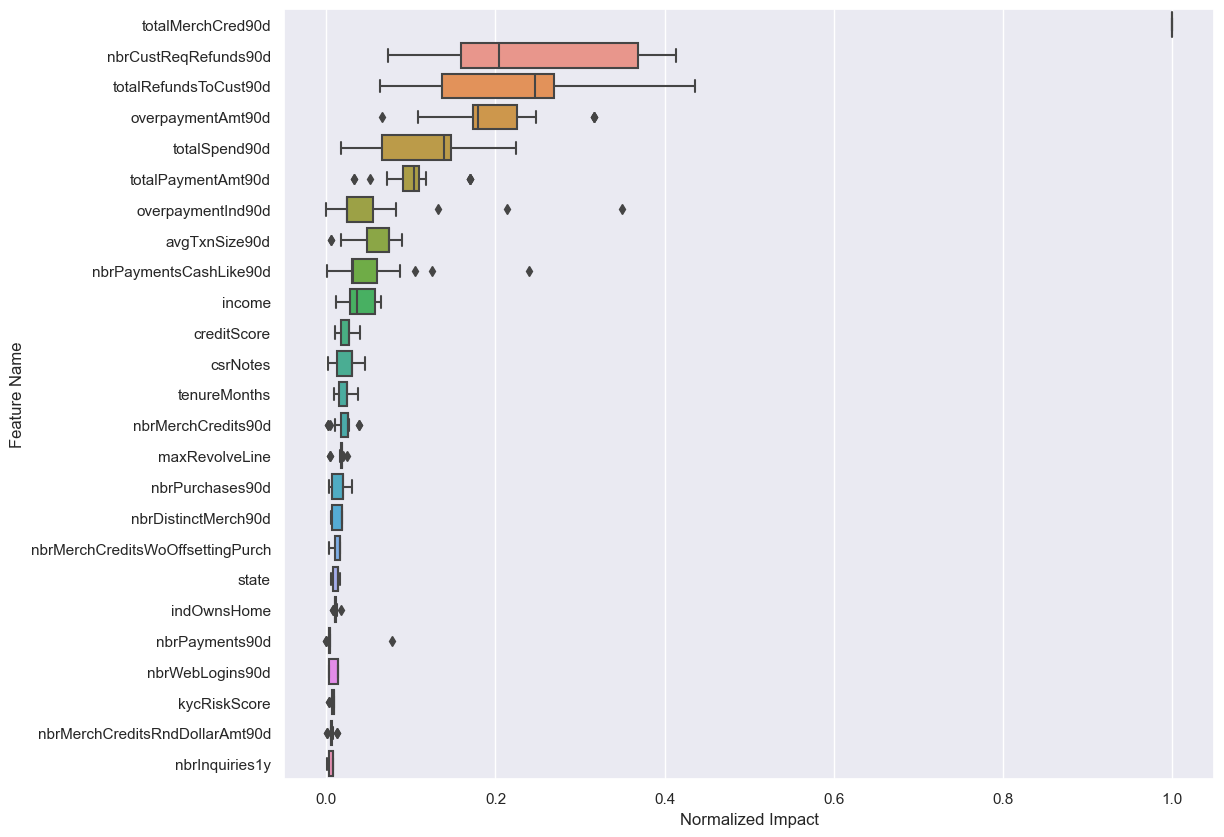

In [13]:
fire.plot_feature_impacts_normalized()

In [14]:
print(
    f"Previous best model has {project_fire.metric} score = {best_model_previous.metrics[project_fire.metric]['crossValidation']} on the cross-validation partition \
on the list of {len(best_model_previous.get_features_used())} features"
)

print(
    f"The new best model has {project_fire.metric} score = {best_model_post_fire.metrics[project_fire.metric]['crossValidation']} on the cross-validation partition \
on the list of {len(best_model_post_fire.get_features_used())} features"
)

Previous best model has LogLoss score = 0.160248 on the cross-validation partition on the list of 28 features
The new best model has LogLoss score = 0.15957000000000002 on the cross-validation partition on the list of 3 features


Using FIRE, you've eliminated 25 features from the model with no real impact on the model's performance.